In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')
sys.path.append("/Users/marissac/Documents/COCOText/coco-text-master")
#sys.path.append("/Users/marissac/Documents/COCOText/github/coco-text")
import caffe
import coco_text
import coco_evaluation
import skimage.io as io
import cv2
import math

import sys

CAFFE_LABEL_TO_CHAR_MAP = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'a',
    11: 'b',
    12: 'c',
    13: 'd',
    14: 'e',
    15: 'f',
    16: 'g',
    17: 'h',
    18: 'i',
    19: 'j',
    20: 'k',
    21: 'l',
    22: 'm',
    23: 'n',
    24: 'o',
    25: 'p',
    26: 'q',
    27: 'r',
    28: 's',
    29: 't',
    30: 'u',
    31: 'v',
    32: 'w',
    33: 'x',
    34: 'y',
    35: 'z',
    36: ' ',
    37: '\0',
    38: '\0'
}


#caffe.set_device(0)
#caffe.set_mode_cpu()

from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL COCO labels
coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_coco_combo_legible.prototxt'
#coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_cocoText.prototxt'
file = open(coco_labelmap_file, 'r')
coco_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), coco_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_digitIn_multiclass_legibleSplit.prototxt'
model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_legibleSplit_SSD_300x300_iter_244000.caffemodel'
#model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_mulitclass_corr_iter_105000.caffemodel'

#model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_digitIn.prototxt'
#model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_iter_140000.caffemodel'

synth_model = '/Users/marissac/caffe/examples/ocr/90ksynth/deploy_2.prototxt'
synth_model_weights = '/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_v2_v00_iter_140000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)
net_synth = caffe.Net(synth_model,
                     synth_model_weights,
                     caffe.TEST)
print net.blobs['data'].data.shape
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

#test = caffe.io.read_mean('/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_mean.binaryproto')
mean_blob = caffe.proto.caffe_pb2.BlobProto()
data_use = open('/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_leveldb_mean.binaryproto','rb').read()
mean_blob.ParseFromString(data_use)
mean_arr = np.array( caffe.io.blobproto_to_array(mean_blob) )
mean_val = np.mean(mean_arr)
print mean_val
#synth_transformer = caffe.io.Transformer({'data': (1, 1, 32, 100)})  # pylint: disable=invalid-name
#synth_transformer.set_mean('data', np.array([mean_val]))
#synth_transformer.set_input_scale('data', 1.0 / 256.0)

synth_transformer = caffe.io.Transformer({'data': net_synth.blobs['data'].data.shape})
synth_transformer.set_transpose('data', (2, 0, 1))
synth_transformer.set_mean('data', np.array([mean_val])/256.0)
#synth_transformer.set_transpose('data', (2, 0, 1))
#synth_transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

dataDir='/Users/marissac/data/coco'
dataType='train2014'

imgSize = 300

ct = coco_text.COCO_Text('/Users/marissac/data/coco/annotations/COCO_Text.json')
#ct.scaleGroundTruth(imgSize,imgSize)
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('language','english')])

# Find images that have text with specified characteristics
#annIdsTemp = ct.getAnnIds(imgIds)
#annTemp = ct.loadAnns(annIdsTemp)
#imgIds = [d['image_id'] for d in annTemp if d['bbox'][3] >=40]
#del annIdsTemp
#del annTemp


(1, 3, 300, 300)
118.088144832
loading annotations into memory...
0:00:02.503747
creating index...
index created!


In [109]:
imgNumFlag = 0 # Flag that specifies if you want to use a random image or an specific image defined by imgNumTest
if imgNumFlag == 0:
    img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
else:
    imgNumTest = 246587 
    img = ct.loadImgs(imgNumTest)[0]
print '/images/%s/%s'%(dataType,img['file_name'])

thresh_use = 0.1 #Define the detection threshold
image = caffe.io.load_image('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
print image.shape
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)



# set net to batch size of 1
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

transformed_image = transformer.preprocess('data',image)
net.blobs['data'].data[...] = transformed_image
#net.blobs['data'].data[...] = test_image
# Forward pass.
net.forward()

detections_out = net.blobs['detection_out'].data

# Parse the outputs.
det_label = detections_out[0,0,:,1]
det_conf = detections_out[0,0,:,2]
det_xmin = detections_out[0,0,:,3]
det_ymin = detections_out[0,0,:,4]
det_xmax = detections_out[0,0,:,5]
det_ymax = detections_out[0,0,:,6]


class_indices = [i for i, label in enumerate(det_label) if ((label == 82) | (label == 81))]
class_conf = det_conf[class_indices]
class_label = det_label[class_indices]
class_xmin = det_xmin[class_indices]
class_ymin = det_ymin[class_indices]
class_xmax = det_xmax[class_indices]
class_ymax = det_ymax[class_indices]

top_indices = [i for i, conf in enumerate(class_conf) if conf > thresh_use]
print top_indices
top_conf = class_conf[top_indices]
top_label_indices = class_label[top_indices].tolist()
top_labels = get_labelname(coco_labelmap, top_label_indices)
top_xmin = class_xmin[top_indices]
top_ymin = class_ymin[top_indices]
top_xmax = class_xmax[top_indices]
top_ymax = class_ymax[top_indices]

num_detect = top_conf.shape[0]


# Get the detections in the format needed for COCOText detection evaliations
detections = coco_text.COCO_Text()
detections.dataset['imgs'] = img
imgUse = img['id']
detections.imgToAnns[imgUse] = list(np.linspace(0,num_detect-1,num_detect))
print detections.imgToAnns[imgUse]
detections.anns = {}
for i in range(0,num_detect):
    xmin_pix = top_xmin[i] * image.shape[1]
    ymin_pix = top_ymin[i] * image.shape[0]
    width_pix = top_xmax[i] * image.shape[1] - xmin_pix
    height_pix = top_ymax[i] * image.shape[0] - ymin_pix
    area_pix = width_pix*height_pix
    category_id = 1
    id_use = i
    image_id = imgUse
    score_use = top_conf[i]
    detections.anns[i] = {'area':area_pix,'bbox':[xmin_pix,ymin_pix,width_pix,height_pix],'category_id':category_id,
                          'id':id_use,'image_id':image_id,'score':score_use}

#our_results_reduced = coco_evaluation.reduceDetections(detections, confidence_threshold = thresh_use)
detection_img = coco_evaluation.getDetections(ct,detections,imgIds = [imgUse],detection_threshold = 0.5)
print detection_img


/images/train2014/COCO_train2014_000000553043.jpg
(499, 640, 3)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
83
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
{'false_positives': [{'eval_id': 1.0}, {'eval_id': 4.0}, {'eval_id': 6.0}, {'eval_id': 7.0}, {'eval_id': 8.0}, {'eval_id': 9.0}], 'false_negatives': [{'gt_id': 1163592}, {'gt_id': 1163594}, {'gt_id': 1163597}, {'gt_id': 1163598}, {'gt_id': 1217619}, {'gt_id': 1217620}, {'gt_id': 1217621}, {'gt_id': 1217622}, {'gt_id': 1217623}, {'gt_id': 1217624}, {'gt_id': 1217625}, {'gt_id': 1217627}], 'true_positives': [{'eval_id': 0.0, 'gt_id': 1043198}, {'eval_id': 5.0, 'gt_id': 1043199}, {'eval_id': 3.0, 'gt_id': 1163593}, {'eval_id': 2.0, 'gt_id': 1217626}]}


4
english
legible
(1, 32, 100)
(1, 39, 1, 23)
bus                    
english
legible
(1, 32, 100)
(1, 39, 1, 23)
liglasoow              
english
legible
(1, 32, 100)
(1, 39, 1, 23)
feasyyt                
english
legible
(1, 32, 100)
(1, 39, 1, 23)
lubclsss               


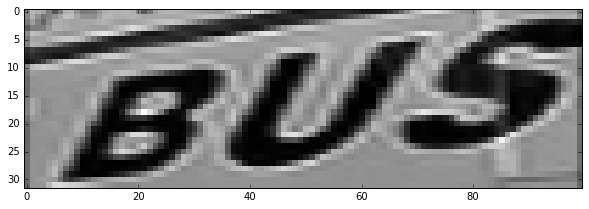

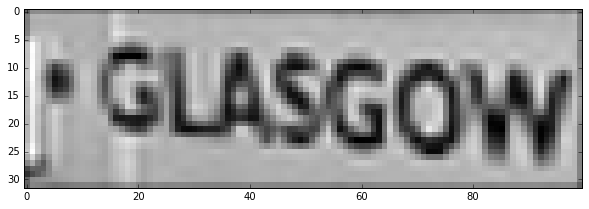

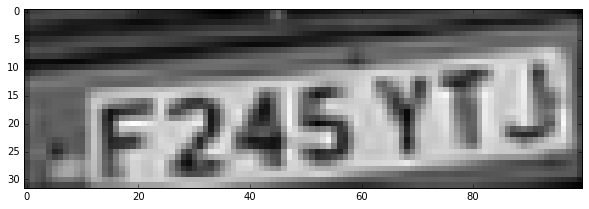

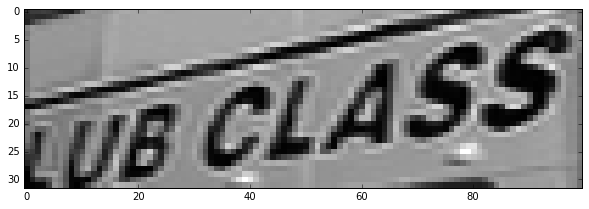

In [110]:
# Perform text reading for just the true positive detections associated with legible and english ground truth
true_detections = detection_img['true_positives']
new_width = 100
new_height =32
num_true_detect = len(true_detections)
img_shape = image.shape

gray_img = np.empty((img_shape[0],img_shape[1],1))
gray_img_temp = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_img[:,:,0] = gray_img_temp
pix_change = 0
runFor = 1
print num_true_detect

for i in range(0,num_true_detect):

    # Check if ground truth is legible and english
    gtAnnInfo = ct.loadAnns(true_detections[i]['gt_id'])
    print gtAnnInfo[0]['language']
    print gtAnnInfo[0]['legibility']
    if (gtAnnInfo[0]['language'] == 'english') & (gtAnnInfo[0]['legibility'] == 'legible'):
        # Get the bounding box associated with the detection
        detect_id = true_detections[i]['eval_id']
        
        detect_ann_temp = detections.anns[detect_id]
        bbox_use = detect_ann_temp['bbox']
        xmin_pix = np.clip(int(math.floor(bbox_use[0]-pix_change)),0,gray_img.shape[1])
        xmax_pix = np.clip(int(math.ceil(bbox_use[0]+bbox_use[2]+pix_change)),0,gray_img.shape[1])
        ymin_pix = np.clip(int(math.floor(bbox_use[1]-pix_change)),0,gray_img.shape[0])
        ymax_pix = np.clip(int(math.ceil(bbox_use[1]+bbox_use[3]+pix_change)),0,gray_img.shape[0])
        text_img = gray_img[ymin_pix:ymax_pix,xmin_pix:xmax_pix]
        #gray_img = cv2.cvtColor(text_img, cv2.COLOR_BGR2GRAY)
        
        synth_transform_image = synth_transformer.preprocess('data',text_img)

        net_synth.blobs['data'].data[0,0,:,:] = synth_transform_image[0,:,:]

        net_synth.forward()
        output = net_synth.blobs['reshape'].data
        text_out = np.reshape(output,(39,23))
        text_max = np.argmax(text_out, axis=0) 
        plt.figure(i+1)
        plt.imshow(synth_transform_image[0,:,:])
        output_word = ''
        for j in range(0,23):
            output_word = output_word + CAFFE_LABEL_TO_CHAR_MAP[text_max[j]-1]
            
        detections.anns[detect_id]['utf8_string'] = output_word.strip()
        print output_word



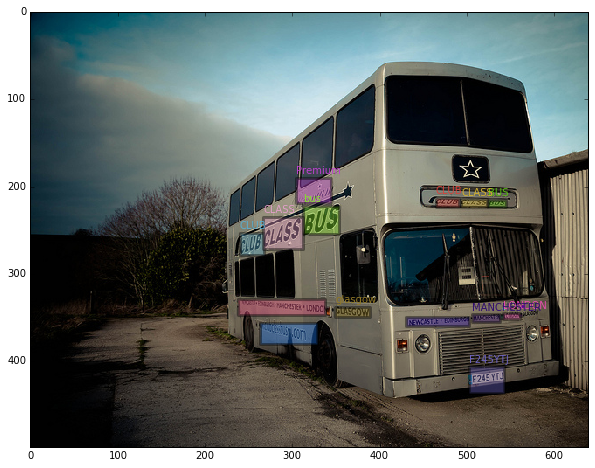

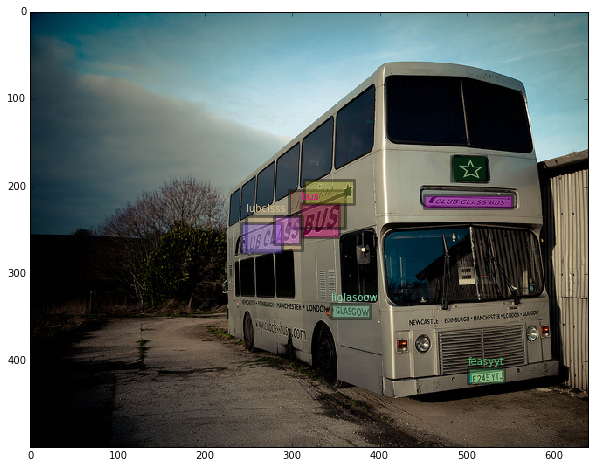

In [111]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure()
plt.imshow(image)
ct.showAnns(anns)

detect_annIds = detections.getAnnIds(imgIds=img['id'])        
detect_anns = detections.loadAnns(detect_annIds)
plt.figure()
plt.imshow(image)
detections.showAnns(detect_anns)

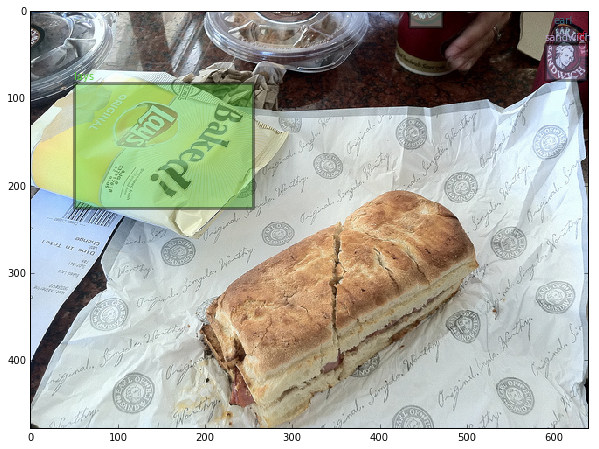

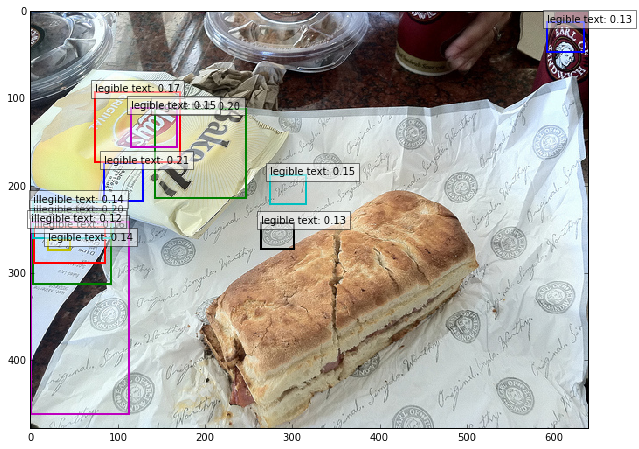

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure()
plt.imshow(image)
ct.showAnns(anns)

plt.figure()
plt.imshow(image)
currentAxis = plt.gca()

#detect_bbox = zeros((top_conf.shape[0],1))
detection_output =[]

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    
    top_xmin_pix = top_xmin[i] * image.shape[1]
    top_ymin_pix = top_ymin[i] * image.shape[0]
    top_width_pix = top_xmax[i] * image.shape[1] - top_xmin_pix
    top_height_pix = top_ymax[i] * image.shape[0] - top_ymin_pix
    bboxTemp = [top_xmin_pix, top_ymin_pix,top_width_pix,top_height_pix]
    detection_output.append({'bounding_box':bboxTemp,'label':i})
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})

In [9]:
# Get detection scores
gt_bboxes = annIds
eval_bboxes = detections.anns
detection_threshold_use = 0.5

iouSave = np.zeros((len(gt_bboxes),top_conf.shape[0]))
detectRes = {}
# results are lists of dicts {gt_id: xxx, eval_id: yyy}
detectRes['true_positives'] = []
detectRes['false_negatives'] = []
detectRes['false_positives'] = []
    
count = 0
for gt_box_id in range(0,len(gt_bboxes)):
    gt_box = anns[gt_box_id]['bbox']
    max_iou = detection_threshold_use
    match = None
    count2 = 0
    for eval_box_id in eval_bboxes:
        eval_box = eval_bboxes[eval_box_id]['bbox']
        #eval_box = eval_box_id['bbox']
        iouSave[count,count2] = coco_evaluation.iou_score(gt_box,eval_box)
        if iouSave[count,count2] > max_iou:
            match = eval_box_id
            max_iou = iouSave[count,count2]
        count2 = count2+1
    if match:
        detectRes['true_positives'].append({'gt_id': gt_box_id, 'eval_id': match})
        del eval_bboxes[match]
        #eval_bboxes.remove(eval_box_id)
    else:
        detectRes['false_negatives'].append({'gt_id': gt_box_id})
    count = count +1
    
if len(eval_bboxes)>0:
    print eval_bboxes
    for eval_box_id in eval_bboxes: 
        detectRes['false_positives'].append({'eval_id': eval_box_id})
    
print detectRes

{0: {'area': 1141.486593710752, 'utf8_string': 'rod', 'image_id': 488060, 'score': 0.18467663, 'bbox': [191.8135176897049, 312.98792362213135, 42.003353834152222, 27.176082134246826], 'category_id': 1, 'id': 0}}
{'false_positives': [{'eval_id': 0}], 'false_negatives': [{'gt_id': 0}, {'gt_id': 1}, {'gt_id': 2}, {'gt_id': 3}], 'true_positives': []}
